In [1]:
import requests
from bs4 import BeautifulSoup
import time
import random
import math
import sqlite3
import pandas as pd
import numpy as np
import urllib
from lxml import etree
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import sqlite3
import pickle
import math
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import Birch
import matplotlib.cm as cm
from sklearn import metrics
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import matplotlib.colors as mcolors
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import Normalizer
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE

from statistics import mean
from itertools import combinations

# Goal

<a id='toc'></a>

# Table of Contents(

### [Feature Engineering](#fe)

### [Regression Model Testing](#rmt)

### [Making Predictions](#mp)

### [Interpreting Results](#ir)

### [Future Work](#fw)

<a id='fe'></a>

[Back to Top of Notebook](#toc)
## Feature Engineering

In [2]:
df = pd.read_pickle("lineupdata.pkl")

In [3]:
df1 = pd.read_pickle('predictionsclass.pkl')

In [4]:
#Boolean output if any duplicates exist in ID column using .duplicated().any()
display(df.Lineups.duplicated().any())

False

In [5]:
#sum of null values present in dataset per category using .isnull().sum()
df.isnull().sum()

Lineups    0
TEAM       0
GP         0
MIN        0
PTS        0
          ..
OppBLK     0
OppBLKA    0
OppPF      0
OppPFD     0
OppPTS     0
Length: 87, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 87 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Lineups        2000 non-null   object 
 1   TEAM           2000 non-null   object 
 2   GP             2000 non-null   int64  
 3   MIN            2000 non-null   float64
 4   PTS            2000 non-null   float64
 5   FGM            2000 non-null   float64
 6   FGA            2000 non-null   float64
 7   FG%            2000 non-null   float64
 8   3PM            2000 non-null   float64
 9   3PA            2000 non-null   float64
 10  3P%            2000 non-null   float64
 11  FTM            2000 non-null   float64
 12  FTA            2000 non-null   float64
 13  FT%            2000 non-null   float64
 14  OREB           2000 non-null   float64
 15  DREB           2000 non-null   float64
 16  REB            2000 non-null   float64
 17  AST            2000 non-null   float64
 18  TOV     

In [7]:
new = df[df.MIN >= 9.6]
new.reset_index(drop=True, inplace = True)

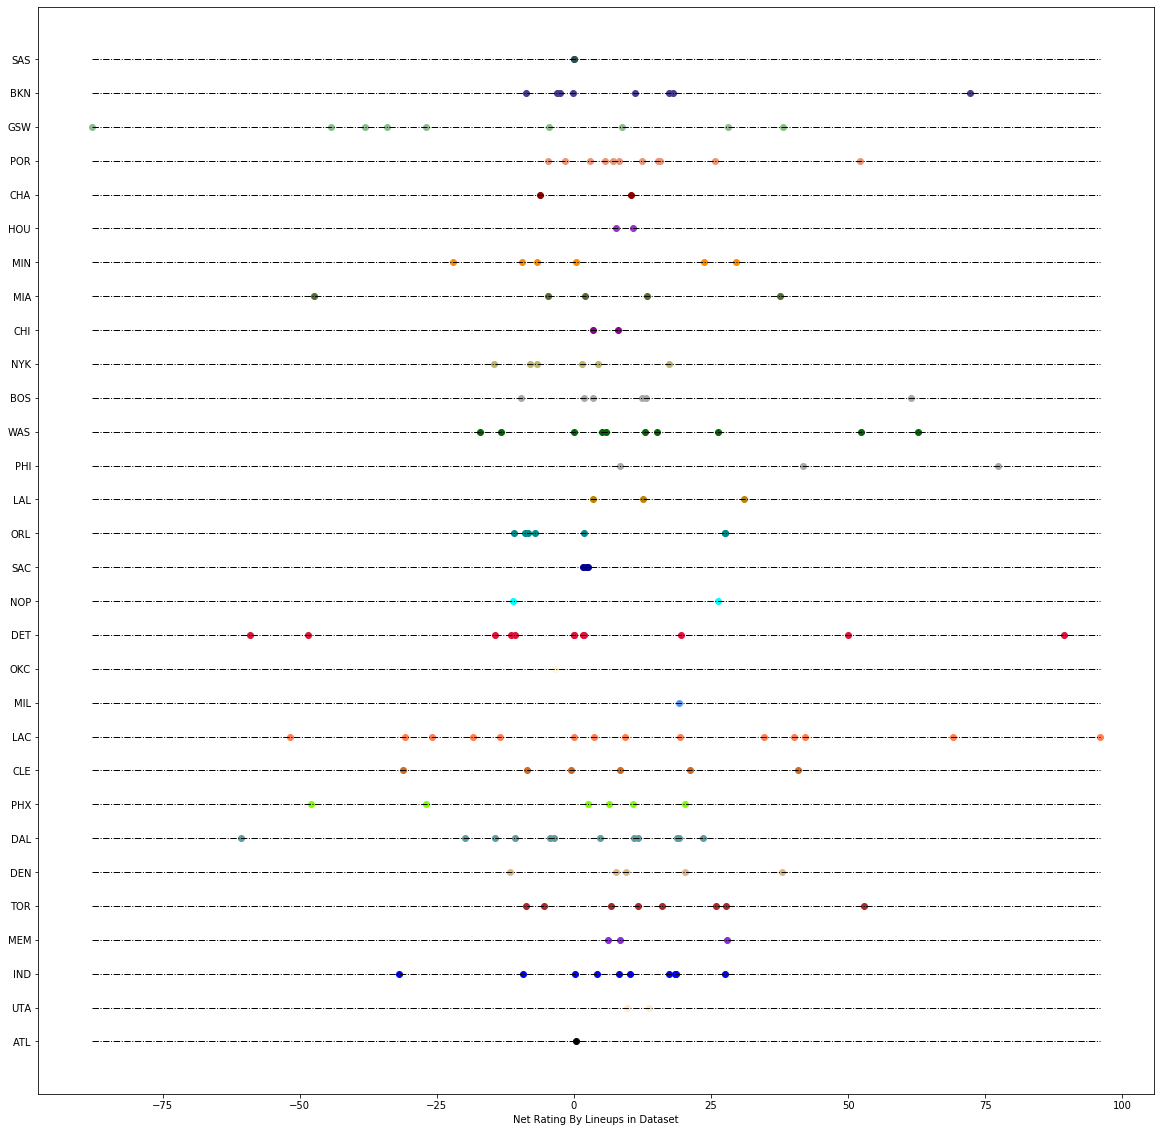

In [8]:
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
colors1 = list(colors.keys())[15:45]
teamcolors = dict(zip(set(new.TEAM),colors1))

fig, ax = plt.subplots(figsize=(20,20))

teamcolorslist = []
for x in set(new.TEAM):
    ax.plot([min(new.NetRtg),max(new.NetRtg)], [x,x], linestyle='-.', color='k', linewidth=1)
    teamcolorslist = []

for idx, x in enumerate(new.TEAM):
    ax.scatter(new.NetRtg.iloc[idx], x, color=teamcolors[x], label=x)

ax.set_xlabel('Net Rating By Lineups in Dataset')

plt.show()

In [493]:
df.rename(columns = {'+/-': 'PM'}, inplace = True)

for column in ['FG%', '3P%', 'FT%', 'OREB%', 'DREB%', 'REB%', 'eFG%', 'TS%',
          '%FGA2PT', '%FGA3PT', '2FGM%AST', '2FGM%UAST', '3FGM%AST', '3FGM%UAST']:
    df[column] = df[column]/100

for column in ['PTS', 'FGM', 'FGA', '3PM', '3PA', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL',
               'BLK', 'PF', 'PM']:
    df[column + '/MIN'] = df[column]/df.MIN
    df[column + '/MIN'] = df[column + '/MIN']/(df[column + '/MIN'].mean())

In [494]:
columns = []
for x in ['PTS', 'FGM', 'FGA', '3PM', '3PA', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'PF', 'PM']:
    columns.append(x + '/MIN')
for x in ['FG%', '3P%', 'FT%', 'AST/TO', 'OREB%', 'DREB%', 'REB%', 'eFG%', 'TS%',
          '%FGA2PT', '%FGA3PT', '2FGM%AST', '2FGM%UAST', '3FGM%AST', '3FGM%UAST']:
    columns.append(x)
notwanted = list(np.setdiff1d(list(df.columns),columns))

data = df.drop(notwanted, axis=1)

In [497]:
#scale data
columns = list(data.columns)
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
data = pd.DataFrame(data, columns=columns)
data.describe()

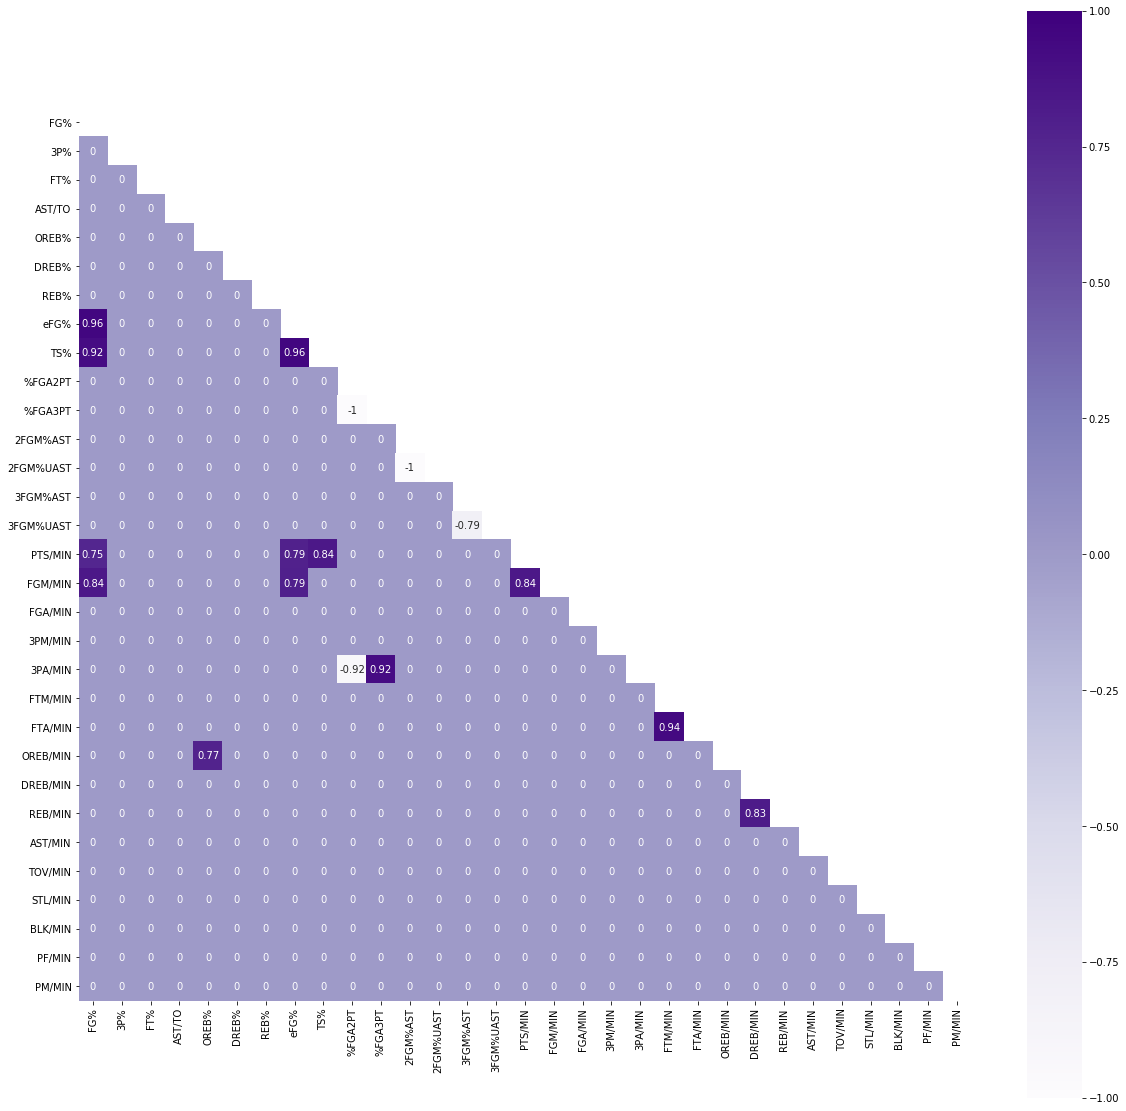

In [499]:
plt.figure(figsize=(10, 10))
#do not display correlation values less than or equal to 0.75
data_corr = data.corr()
data_corr[np.abs(data_corr)<.75] = 0
#mask upper half of matrix
mask = np.zeros_like(data_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data_corr, mask=mask, center=0, annot=True, cmap="Purples", square = True, vmin=-1)

In [500]:
data.drop(['PTS/MIN', 'FGM/MIN', 'FTA/MIN', 'OREB/MIN',
           'REB/MIN', '3FGM%UAST', '%FGA2PT', '2FGM%UAST',
           '3PA/MIN', 'eFG%', 'FG%'], axis = 1, inplace = True)

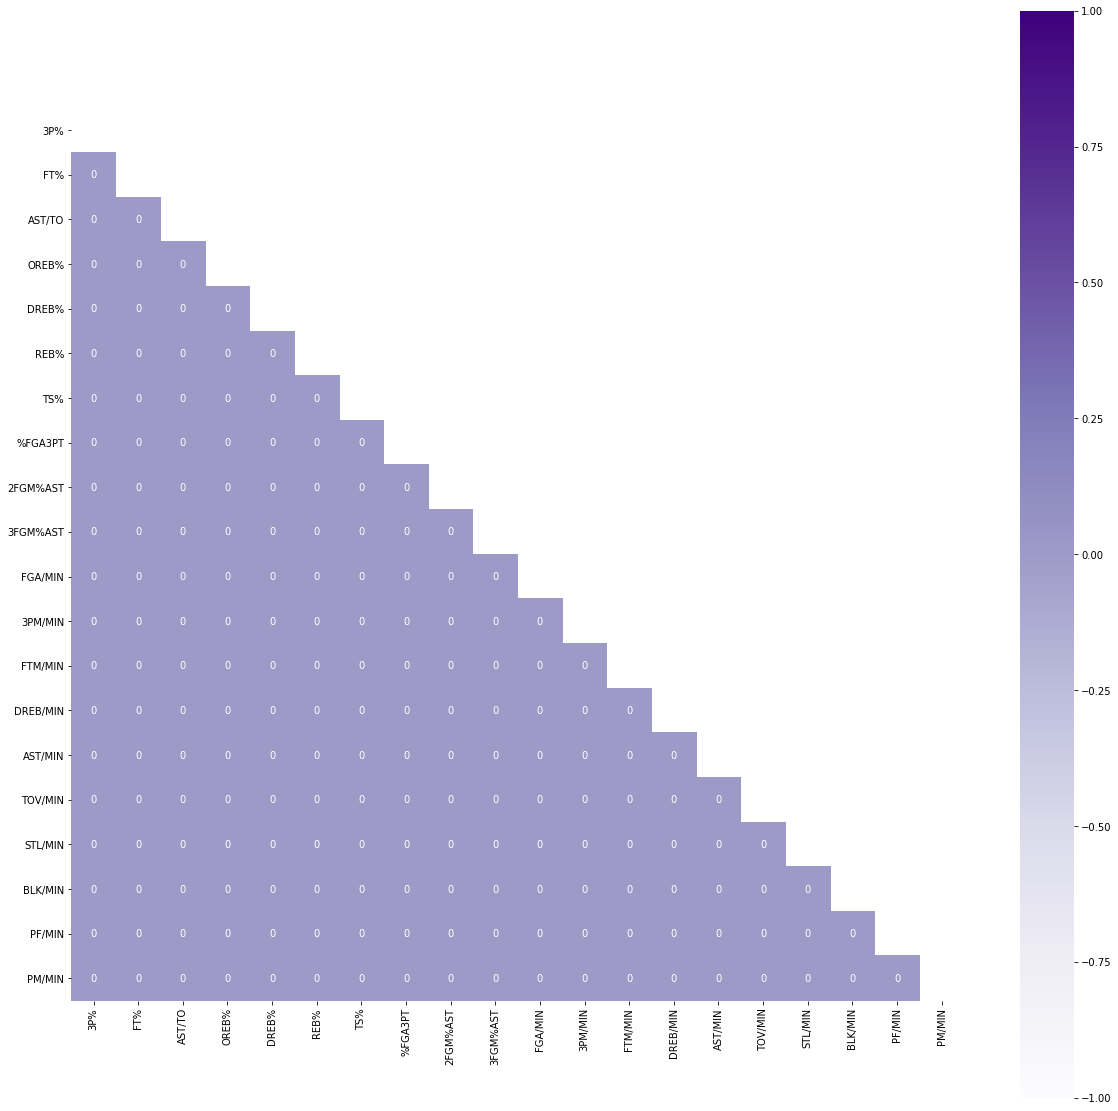

In [501]:
plt.figure(figsize=(10, 10))
#do not display correlation values less than or equal to 0.75
data_corr = data.corr()
data_corr[np.abs(data_corr)<.75] = 0
#mask upper half of matrix
mask = np.zeros_like(data_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data_corr, mask=mask, center=0, annot=True, cmap="Purples", square = True, vmin=-1)

In [503]:
data['NetRtg'] = df.NetRtg

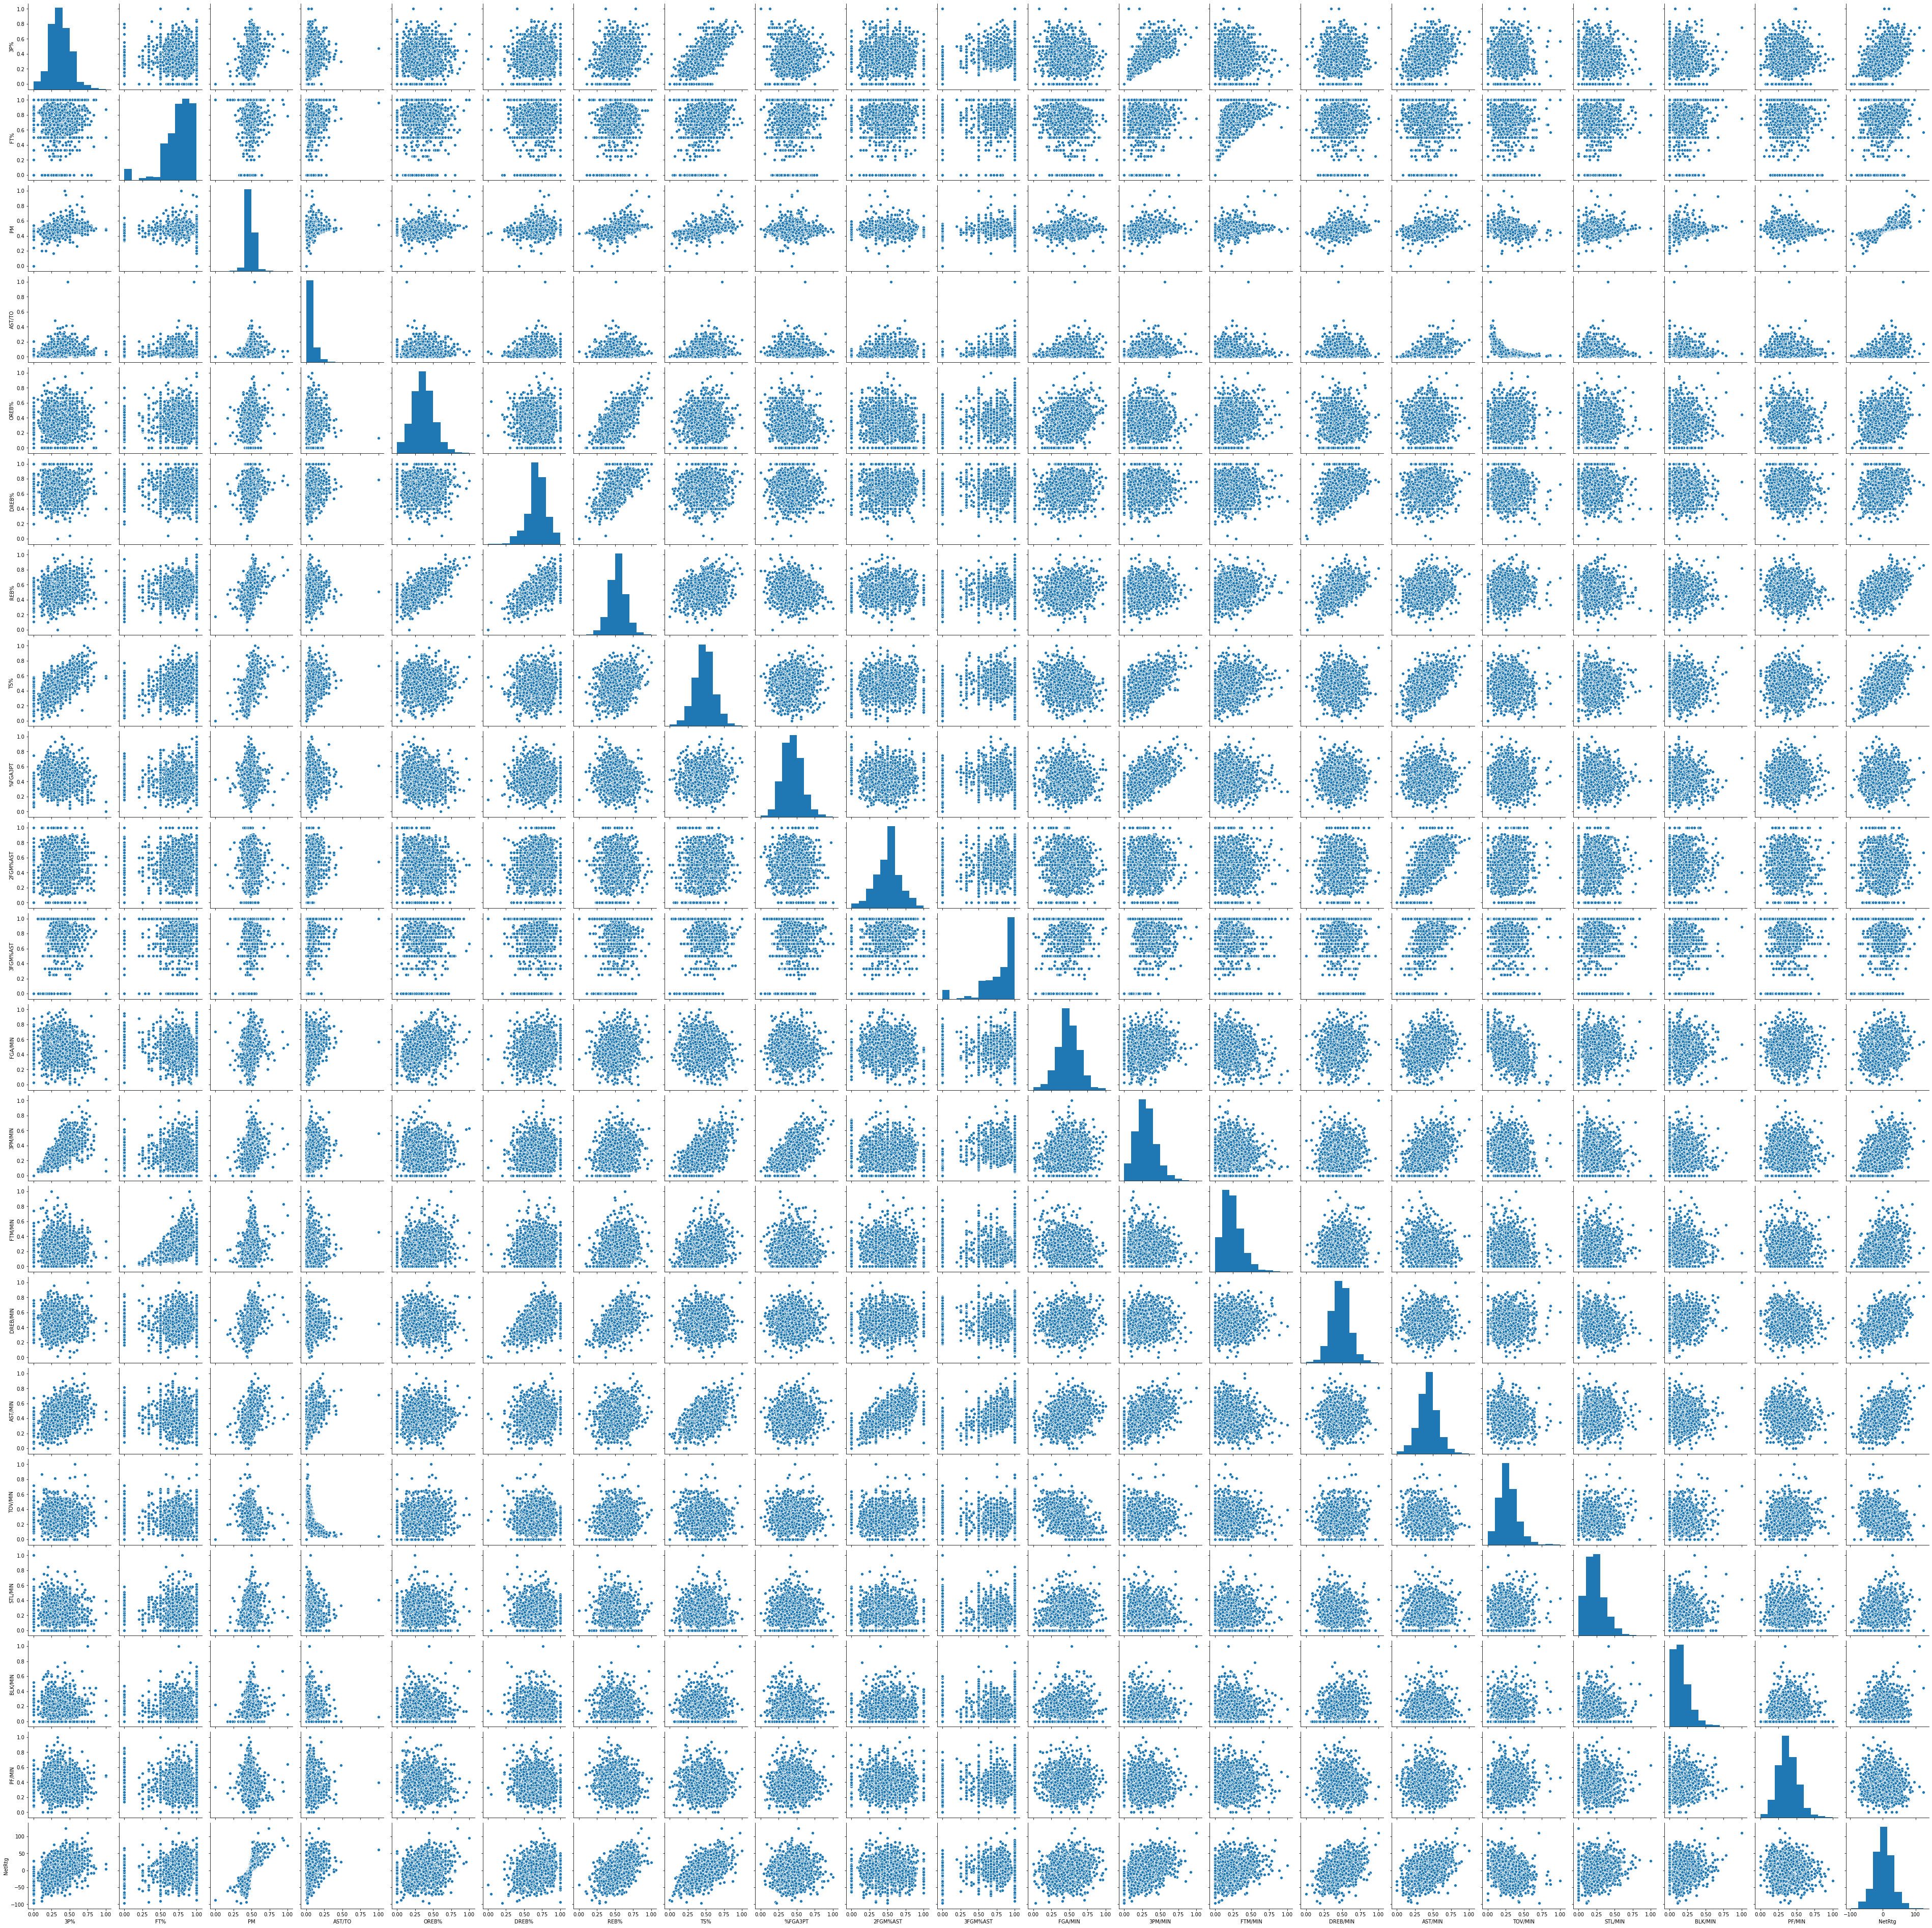

In [243]:
sns.pairplot(data)

<a id='rmt'></a>

[Back to Top of Notebook](#toc)
## Regression Model Testing

In [504]:
predictors = data.drop('NetRtg', axis=1)
predictors_int = sm.add_constant(predictors)

X_train, X_test, y_train, y_test = train_test_split(predictors_int, data.NetRtg, test_size = 0.3, random_state = 42)

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

#run algorithm over train set to find best selectors
resultingfeatures = stepwise_selection(X_train, y_train)

#we print our results to find the features to include in our model
print('resulting features:')
print(resultingfeatures)

Add  PM/MIN                         with p-value 0.0
Add  const                          with p-value 0.0
Add  PF/MIN                         with p-value 1.15524e-10
Add  TOV/MIN                        with p-value 2.37052e-08
Add  FTM/MIN                        with p-value 2.83923e-08
Add  FGA/MIN                        with p-value 5.55934e-12
Add  REB%                           with p-value 9.18144e-08
Add  STL/MIN                        with p-value 9.37333e-06
Add  DREB/MIN                       with p-value 8.39876e-05
Add  TS%                            with p-value 6.09055e-07
Add  OREB%                          with p-value 4.64687e-06
Drop REB%                           with p-value 0.765627
resulting features:
['PM/MIN', 'const', 'PF/MIN', 'TOV/MIN', 'FTM/MIN', 'FGA/MIN', 'STL/MIN', 'DREB/MIN', 'TS%', 'OREB%']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 NetRtg   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     3609.
Date:                Sat, 20 Jun 2020   Prob (F-statistic):               0.00
Time:                        10:49:33   Log-Likelihood:                -4410.2
No. Observations:                1400   AIC:                             8840.
Df Residuals:                    1390   BIC:                             8893.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -95.9351      1.294    -74.114      0.000     -98.474     -93.396
OREB%          8.3642      1.271      6.581      0.000       5.871      10.857
TS%           10.9118      1.672      6.526      0.000       7.632      14.192
FGA/MIN      -11.0395      1.464     -7.538      0.000     -13.912      -8.167
FTM/MIN      -11.8264      1.280     -9.242      0.000     -14.337      -9.316
DREB/MIN      14.4088      1.585      9.093      0.000      11.301      17.517
TOV/MIN      -19.0403      1.588    -11.990      0.000     -22.155     -15.925
STL/MIN        8.8319      1.261      7.004      0.000       6.358      11.306
PF/MIN         8.6587      1.152      7.514      0.000       6.398      10.919
PM/MIN       207.5936      2.346     88.490      0.000     202.992     212.196
==============================================================================
Omnibus:                       25.866   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.756
Skew:                           0.029   Prob(JB):                     1.57e-11
Kurtosis:                       3.922   Cond. No.                         31.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Train Mean Squared Error: 31.894987344003916
Test Mean Squared Error: 30.668462047010806
difference: 0.11
R-Squared of Train Set:  0.9589649680667562
R-Squared of Test Set:  0.9551109854181716
Mean Absolute Error of Test Set:  4.1815637597181015
Root Mean Squared Error of Test Set:  5.537911343368617


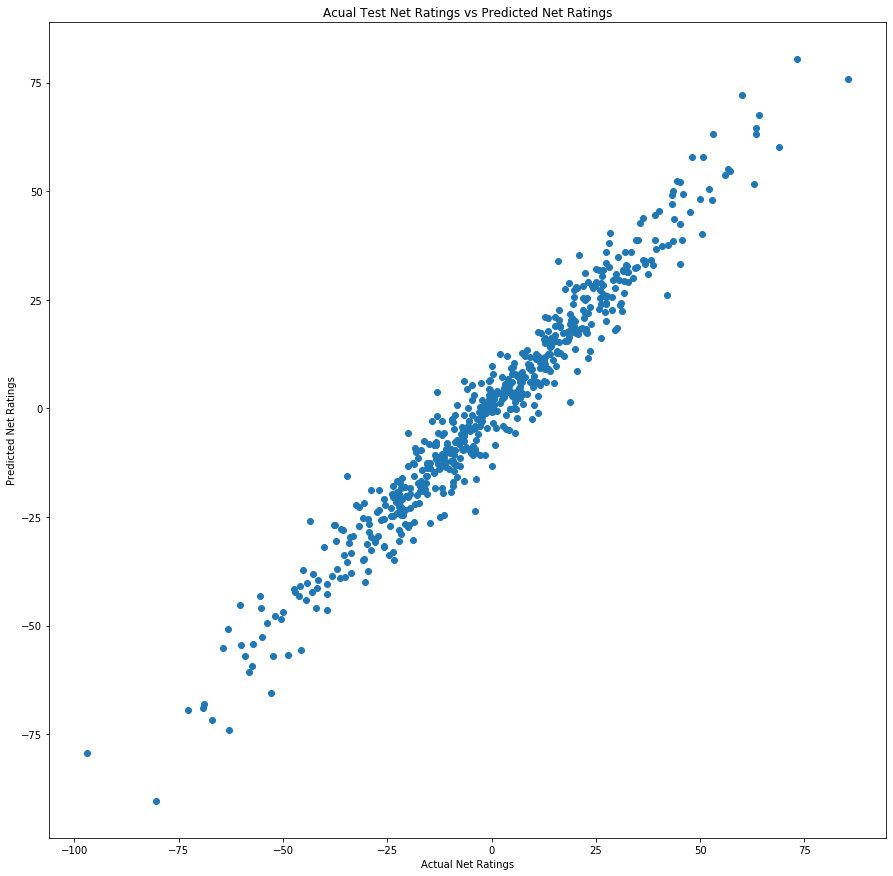

In [505]:
notwanted = list(np.setdiff1d(list(data.columns),['PM/MIN', 'PF/MIN', 'TOV/MIN', 'FTM/MIN', 'FGA/MIN', 'STL/MIN', 'DREB/MIN', 'TS%', 'OREB%']))
predictors = data.drop(notwanted, axis=1)
predictors_int = sm.add_constant(predictors)

X_train, X_test, y_train, y_test = train_test_split(predictors_int, data['NetRtg'], test_size=0.3, random_state=42)


model = sm.OLS(y_train,X_train).fit()
display(model.summary())

y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)


#plot scatter plot of actual y_test values and predicted y_test values
plt.figure(figsize=(15, 15))
plt.scatter(y_test, y_hat_test)
plt.title('Acual Test Net Ratings vs Predicted Net Ratings')
plt.xlabel('Actual Net Ratings')
plt.ylabel('Predicted Net Ratings')

#print out our statistics summary of predicted values using sklearn metrics
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squared Error:', train_mse)
print('Test Mean Squared Error:', test_mse)
print('difference: ' + str(np.round(abs(np.sqrt(train_mse)-np.sqrt(test_mse)),2)))
r2train = r2_score(y_train, y_hat_train)
r2test = r2_score(y_test, y_hat_test)
print('R-Squared of Train Set: ', r2train)
print('R-Squared of Test Set: ', r2test)
mae = mean_absolute_error(y_test, y_hat_test)
rms = np.sqrt(mean_squared_error(y_test, y_hat_test))
print('Mean Absolute Error of Test Set: ', mae)
print('Root Mean Squared Error of Test Set: ', rms)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 NetRtg   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     5057.
Date:                Sat, 20 Jun 2020   Prob (F-statistic):               0.00
Time:                        13:33:42   Log-Likelihood:                -6285.5
No. Observations:                2000   AIC:                         1.259e+04
Df Residuals:                    1990   BIC:                         1.265e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -96.2079      1.093    -88.053      0.000     -98.351     -94.065
OREB%          7.1573      1.018      7.031      0.000       5.161       9.154
TS%            9.7576      1.398      6.981      0.000       7.016      12.499
FGA/MIN       -9.8849      1.213     -8.150      0.000     -12.264      -7.506
FTM/MIN      -12.5457      1.042    -12.042      0.000     -14.589     -10.502
DREB/MIN      13.5077      1.315     10.272      0.000      10.929      16.087
TOV/MIN      -16.9493      1.334    -12.709      0.000     -19.565     -14.334
STL/MIN        8.5821      1.062      8.079      0.000       6.499      10.665
PF/MIN         9.1475      0.958      9.545      0.000       7.268      11.027
PM/MIN       208.8025      1.951    107.019      0.000     204.976     212.629
==============================================================================
Omnibus:                       35.726   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.618
Skew:                           0.027   Prob(JB):                     7.63e-16
Kurtosis:                       3.912   Cond. No.                         31.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Mean Squared Error: 30.668462047010806
R-Squared:  0.9581109897072786
Mean Absolute Error:  4.231739568254477
Root Mean Squared Error:  5.605851443865277


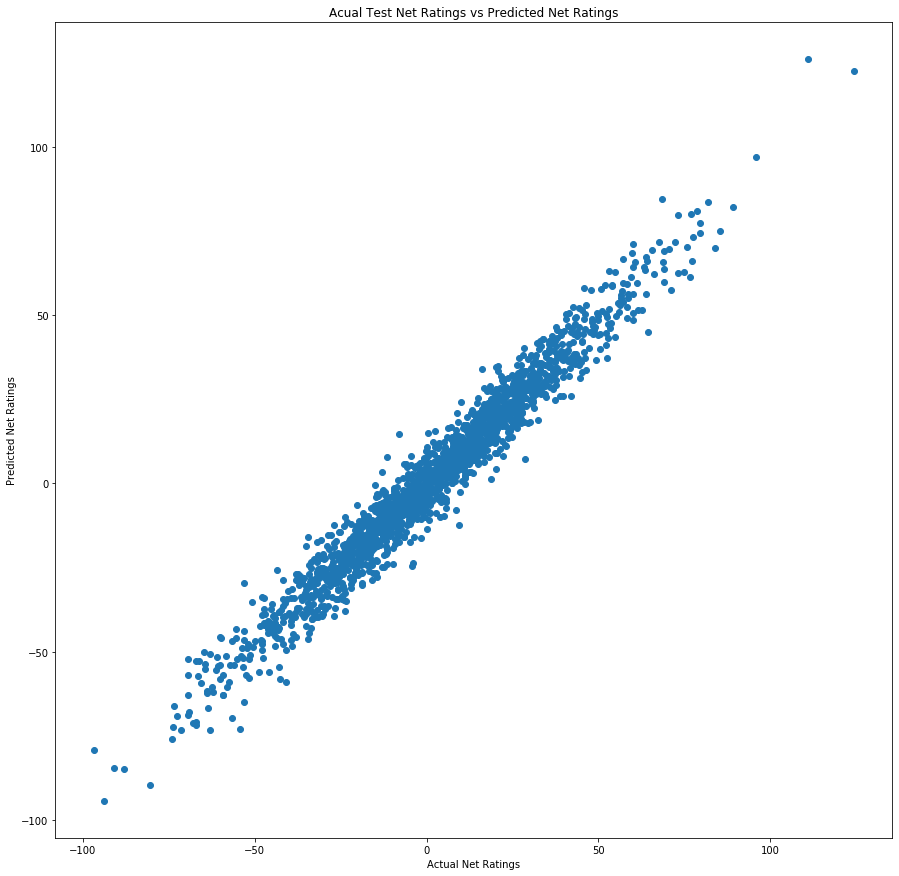

In [535]:
notwanted = list(np.setdiff1d(list(data.columns),['PM/MIN', 'PF/MIN', 'TOV/MIN', 'FTM/MIN', 'FGA/MIN', 'STL/MIN', 'DREB/MIN', 'TS%', 'OREB%']))
predictors = data.drop(notwanted, axis=1)
predictors_int = sm.add_constant(predictors)
model = sm.OLS(data['NetRtg'],predictors_int).fit()
display(model.summary())

#serialize model
filename = 'finalized_reg_model.dat'
pickle.dump(model, open(filename, 'wb'))

y_hat = model.predict(predictors_int)


#plot scatter plot of actual y_test values and predicted y_test values
plt.figure(figsize=(15, 15))
plt.scatter(data['NetRtg'], y_hat)
plt.title('Acual Test Net Ratings vs Predicted Net Ratings')
plt.xlabel('Actual Net Ratings')
plt.ylabel('Predicted Net Ratings')

#print out our statistics summary of predicted values using sklearn metrics
mse = mean_squared_error(data['NetRtg'], y_hat)
print('Mean Squared Error:', test_mse)
r2 = r2_score(data['NetRtg'], y_hat)
print('R-Squared: ', r2)
mae = mean_absolute_error(data['NetRtg'], y_hat)
rms = np.sqrt(mean_squared_error(data['NetRtg'], y_hat))
print('Mean Absolute Error: ', mae)
print('Root Mean Squared Error: ', rms)

<a id='mp'></a>

[Back to Top of Notebook](#toc)
## Making Predictions

In [7]:
comb = combinations(list(range(0,38)), 5)
cutoff = 0.75*mean([138765934,135025925,134341791,133664718,133474030,133220515,132512645,131527930,130763093,130655276,
130445720,130325319,130273147,129372022,128593098,127379136,125109724,124399147,123174560,123108207,
121899425,121867856,121225607,120896498,117390118,117325921,114708526,114665634,114377720,109714940])
validlineups = []
for x in list(comb):
    if (df1.Salary[x[0]] + df1.Salary[x[1]] + df1.Salary[x[2]] + df1.Salary[x[3]] + df1.Salary[x[4]]) <= cutoff:
        validlineups.append(x)

In [ ]:
test_data = pd.DataFrame()
for idx, x in enumerate(validlineups):
    test_data.loc[idx, 'PM/MIN'] = ((df1.BPM.iloc[x[0]]/df1['MP/G'].iloc[x[0]]) + (df1.BPM.iloc[x[1]]/df1['MP/G'].iloc[x[1]]) + (df1.BPM.iloc[x[2]]/df1['MP/G'].iloc[x[2]]) + (df1.BPM.iloc[x[3]]/df1['MP/G'].iloc[x[3]]) + (df1.BPM.iloc[x[4]]/df1['MP/G'].iloc[x[4]]))
    test_data.loc[idx, 'FGA/MIN'] = ((df1['FGA/G'].iloc[x[0]]/df1['MP/G'].iloc[x[0]]) + (df1['FGA/G'].iloc[x[1]]/df1['MP/G'].iloc[x[1]]) + (df1['FGA/G'].iloc[x[2]]/df1['MP/G'].iloc[x[2]]) + (df1['FGA/G'].iloc[x[3]]/df1['MP/G'].iloc[x[3]]) + (df1['FGA/G'].iloc[x[4]]/df1['MP/G'].iloc[x[4]]))
    test_data.loc[idx, 'FTM/MIN'] = ((df1['FTMade/G'].iloc[x[0]]/df1['MP/G'].iloc[x[0]]) + (df1['FTMade/G'].iloc[x[1]]/df1['MP/G'].iloc[x[1]]) + (df1['FTMade/G'].iloc[x[2]]/df1['MP/G'].iloc[x[2]]) + (df1['FTMade/G'].iloc[x[3]]/df1['MP/G'].iloc[x[3]]) + (df1['FTMade/G'].iloc[x[4]]/df1['MP/G'].iloc[x[4]]))
    test_data.loc[idx, 'DREB/MIN'] = ((df1['DRB/G'].iloc[x[0]]/df1['MP/G'].iloc[x[0]]) + (df1['DRB/G'].iloc[x[1]]/df1['MP/G'].iloc[x[1]]) + (df1['DRB/G'].iloc[x[2]]/df1['MP/G'].iloc[x[2]]) + (df1['DRB/G'].iloc[x[3]]/df1['MP/G'].iloc[x[3]]) + (df1['DRB/G'].iloc[x[4]]/df1['MP/G'].iloc[x[4]])) 
    test_data.loc[idx, 'TOV/MIN'] = ((df1['TOV/G'].iloc[x[0]]/df1['MP/G'].iloc[x[0]]) + (df1['TOV/G'].iloc[x[1]]/df1['MP/G'].iloc[x[1]]) + (df1['TOV/G'].iloc[x[2]]/df1['MP/G'].iloc[x[2]]) + (df1['TOV/G'].iloc[x[3]]/df1['MP/G'].iloc[x[3]]) + (df1['TOV/G'].iloc[x[4]]/df1['MP/G'].iloc[x[4]]))
    test_data.loc[idx, 'STL/MIN'] = ((df1['STL/G'].iloc[x[0]]/df1['MP/G'].iloc[x[0]]) + (df1['STL/G'].iloc[x[1]]/df1['MP/G'].iloc[x[1]]) + (df1['STL/G'].iloc[x[2]]/df1['MP/G'].iloc[x[2]]) + (df1['STL/G'].iloc[x[3]]/df1['MP/G'].iloc[x[3]]) + (df1['STL/G'].iloc[x[4]]/df1['MP/G'].iloc[x[4]]))
    test_data.loc[idx, 'PF/MIN'] = ((df1['PF/G'].iloc[x[0]]/df1['MP/G'].iloc[x[0]]) + (df1['PF/G'].iloc[x[1]]/df1['MP/G'].iloc[x[1]]) + (df1['PF/G'].iloc[x[2]]/df1['MP/G'].iloc[x[2]]) + (df1['PF/G'].iloc[x[3]]/df1['MP/G'].iloc[x[3]]) + (df1['PF/G'].iloc[x[4]]/df1['MP/G'].iloc[x[4]]))
    
    test_data.loc[idx, 'OREB%'] = df1.PercORB.iloc[x[0]] + df1.PercORB.iloc[x[1]] + df1.PercORB.iloc[x[2]] + df1.PercORB.iloc[x[3]] + df1.PercORB.iloc[x[4]]
    test_data.loc[idx, 'TS%'] = mean([df1.TSPerc.iloc[x[0]],df1.TSPerc.iloc[x[1]],df1.TSPerc.iloc[x[2]],df1.TSPerc.iloc[x[3]],df1.TSPerc.iloc[x[4]]])
    print(idx)

In [528]:
test_data['PM/MIN'] = test_data['PM/MIN']/test_data['PM/MIN'].mean()
test_data['FGA/MIN'] = test_data['FGA/MIN']/test_data['FGA/MIN'].mean()
test_data['DREB/MIN'] = test_data['DREB/MIN']/test_data['DREB/MIN'].mean()
test_data['TOV/MIN'] = test_data['TOV/MIN']/test_data['TOV/MIN'].mean()
test_data['STL/MIN'] = test_data['STL/MIN']/test_data['STL/MIN'].mean()
test_data['FTM/MIN'] = test_data['FTM/MIN']/test_data['FTM/MIN'].mean()
test_data['PF/MIN'] = test_data['PF/MIN']/test_data['PF/MIN'].mean()

In [602]:
test_data.to_pickle('lineups_test_data.pkl')

In [526]:
test_data = pd.read_pickle('lineups_test_data.pkl')

In [604]:
display(test_data.head())
test_data.describe()

PM/MIN   FGA/MIN   FTM/MIN  DREB/MIN   TOV/MIN   STL/MIN    PF/MIN  \
0 -3.531997  0.922489  0.828070  0.809873  0.899799  1.024884  1.048802   
1 -0.994897  0.954321  0.887529  0.996797  0.963493  0.976383  1.057265   
2 -1.294489  0.993436  0.974374  0.878984  0.995065  1.013557  1.011631   
3 -0.390968  0.990194  0.977613  0.957086  1.019263  1.049994  1.049294   
4 -1.510849  0.994378  0.926890  0.806682  0.997192  1.033520  1.003643   

       OREB%       TS%  
0  23.683168  0.552195  
1  34.916501  0.565735  
2  24.272057  0.560112  
3  28.799834  0.561668  
4  23.292692  0.557554

PM/MIN        FGA/MIN        FTM/MIN       DREB/MIN  \
count  477365.000000  477365.000000  477365.000000  477365.000000   
mean        1.000000       1.000000       1.000000       1.000000   
std         3.384927       0.114138       0.236175       0.158382   
min       -13.032835       0.622719       0.394935       0.547394   
25%        -1.294590       0.918625       0.818826       0.885804   
50%         1.046546       0.998583       0.982432       0.988242   
75%         3.332119       1.080045       1.162206       1.102927   
max        13.228739       1.416594       2.024115       1.705151   

             TOV/MIN        STL/MIN         PF/MIN          OREB%  \
count  477365.000000  477365.000000  477365.000000  477365.000000   
mean        1.000000       1.000000       1.000000      29.043416   
std         0.133181       0.065875       0.105090       7.792511   
min         0.644610       0.750387       0.689583       8.421140   
25%         0.899074       0.954512       0.923791      23.433485   
50%         0.994207       0.999067       0.992259      28.694167   
75%         1.093476       1.044395       1.068705      34.264583   
max         1.531024       1.275085       1.493373      63.204762   

                 TS%  
count  477365.000000  
mean        0.574016  
std         0.018452  
min         0.503397  
25%         0.561465  
50%         0.573603  
75%         0.586241  
max         0.648872

In [531]:
notwanted = list(np.setdiff1d(list(df.columns),['PM/MIN', 'PF/MIN', 'TOV/MIN', 'FTM/MIN', 'FGA/MIN', 'STL/MIN', 'DREB/MIN', 'TS%', 'OREB%']))
df.drop(notwanted, axis=1).describe()

OREB%          TS%      FGA/MIN      FTM/MIN     DREB/MIN  \
count  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000   
mean      0.266832     0.570313     1.000000     1.000000     1.000000   
std       0.111456     0.097636     0.111062     0.576840     0.241420   
min       0.000000     0.234000     0.635882     0.000000     0.093025   
25%       0.196000     0.509000     0.934358     0.610744     0.842041   
50%       0.267000     0.572000     0.999244     0.913662     1.001812   
75%       0.333000     0.630000     1.065860     1.303417     1.149138   
max       0.750000     0.938000     1.392885     4.218956     1.993402   

           TOV/MIN      STL/MIN       PF/MIN       PM/MIN  
count  2000.000000  2000.000000  2000.000000  2000.000000  
mean      1.000000     1.000000     1.000000     1.000000  
std       0.443130     0.587637     0.354109    17.591826  
min       0.000000     0.000000     0.000000   -62.681444  
25%       0.705300     0.599974     0.753167    -9.700700  
50%       0.963130     0.954504     0.974687     1.188336  
75%       1.246870     1.312443     1.214763    11.961630  
max       3.571283     4.361349     2.630107    83.148854

In [542]:
#scale data
columns = list(test_data.columns)
scaler = MinMaxScaler()
pred_data = scaler.fit_transform(test_data)
pred_data = pd.DataFrame(pred_data, columns=columns)

In [543]:
#serialize model
filename = 'finalized_reg_model.dat'
model = pickle.load(open(filename, 'rb'))
pred_data_int = sm.add_constant(pred_data)
predictions = model.predict(pred_data_int)

In [659]:
ci = model.get_prediction(pred_data_int).summary_frame()[['mean_ci_lower', 'mean_ci_upper']]
ci['variability'] = abs((ci.mean_ci_upper - ci.mean_ci_lower) / abs(ci.mean_ci_upper))

In [545]:
pred_final = pd.concat([test_data, pd.Series(predictions)], axis = 1)
pred_final.rename(columns = {0: 'NetRtg'}, inplace = True)
pred_final = pd.concat([pred_final, pd.Series(validlineups)], axis = 1)
pred_final.rename(columns = {0: 'Lineups'}, inplace = True)

In [572]:
for idx, val in enumerate(df1.PercasSG):
    df1.loc[idx, 'Score'] = val + (df1.PercasSF.iloc[idx]*2) + (df1.PercasPF.iloc[idx]*3) + (df1.PercasC.iloc[idx]*4)
for idx, val in enumerate(pred_final.Lineups):
    pred_final.loc[idx, 'Score'] = df1.Score.iloc[val[0]] + df1.Score.iloc[val[1]] + df1.Score.iloc[val[2]] + df1.Score.iloc[val[3]] + df1.Score.iloc[val[4]]

In [660]:
pred_final['variability'] = ci.variability

In [668]:
pred_final.to_pickle('pred_data.pkl')

<a id='ir'></a>

[Back to Top of Notebook](#toc)
## Interpreting Results

In [9]:
pred_final = pd.read_pickle('pred_data.pkl')

In [10]:
pred_final

PM/MIN   FGA/MIN   FTM/MIN  DREB/MIN   TOV/MIN   STL/MIN    PF/MIN  \
0      -3.531997  0.922489  0.828070  0.809873  0.899799  1.024884  1.048802   
1      -0.994897  0.954321  0.887529  0.996797  0.963493  0.976383  1.057265   
2      -1.294489  0.993436  0.974374  0.878984  0.995065  1.013557  1.011631   
3      -0.390968  0.990194  0.977613  0.957086  1.019263  1.049994  1.049294   
4      -1.510849  0.994378  0.926890  0.806682  0.997192  1.033520  1.003643   
...          ...       ...       ...       ...       ...       ...       ...   
477360  4.356148  0.962965  0.992195  1.048895  0.901503  1.066624  1.081396   
477361  1.729346  0.970393  0.999665  1.046472  0.943962  1.010322  1.034998   
477362  2.359984  0.904056  0.979263  1.068203  0.929792  1.002404  1.142579   
477363  2.748783  0.896138  0.967132  1.096229  0.918877  1.024838  1.191688   
477364  2.774692  0.869430  0.926946  1.100925  0.925214  1.056716  1.165603   

            OREB%       TS%     NetRtg               Lineups      Score  \
0       23.683168  0.552195 -23.959946       (0, 1, 2, 3, 4)  10.671889   
1       34.916501  0.565735  -1.326952       (0, 1, 2, 3, 5)  13.572495   
2       24.272057  0.560112 -11.232068       (0, 1, 2, 3, 6)  10.993606   
3       28.799834  0.561668  -9.309096       (0, 1, 2, 3, 7)  12.355828   
4       23.292692  0.557554 -14.741729       (0, 1, 2, 3, 8)  10.144400   
...           ...       ...        ...                   ...        ...   
477360  32.605000  0.597547  40.710211  (32, 33, 34, 35, 37)  15.798500   
477361  32.930000  0.577080  12.715147  (32, 33, 34, 36, 37)  15.578500   
477362  36.205000  0.599980  46.563906  (32, 33, 35, 36, 37)  16.261000   
477363  38.325000  0.604450  52.745598  (32, 34, 35, 36, 37)  17.530000   
477364  38.288333  0.600597  45.868810  (33, 34, 35, 36, 37)  16.849333   

        variability  
0          0.072984  
1          2.761777  
2          0.124898  
3          0.184644  
4          0.101473  
...             ...  
477360     0.071494  
477361     0.136815  
477362     0.063370  
477363     0.063121  
477364     0.074238  

[477365 rows x 13 columns]

In [11]:
pred_final_restrict = pred_final[pred_final.Score >= 6]
pred_final_restrict = pred_final_restrict[pred_final_restrict.Score <= 12.9]
pred_final_restrict = pred_final_restrict[pred_final_restrict.variability <= pred_final_restrict.describe().variability['25%']]
pred_final_restrict.reset_index(drop = True, inplace = True)
pred_final_restrict.sort_values(by = 'NetRtg', ascending=False).head(10)

PM/MIN   FGA/MIN   FTM/MIN  DREB/MIN   TOV/MIN   STL/MIN    PF/MIN  \
50507   8.785763  1.112799  1.599028  1.083226  1.258954  1.062402  1.063387   
26471   9.722622  1.169362  1.531606  1.215932  1.283453  0.930997  1.053013   
25599   8.017684  1.154474  1.694516  0.946087  1.292529  1.018292  1.043286   
46138   7.882241  1.116041  1.595789  1.005124  1.234756  1.025964  1.025724   
64200   8.438040  1.129363  1.699072  1.010620  1.225082  1.064702  1.027081   
70507   7.605211  1.109223  1.343411  1.124866  1.163695  0.962599  1.015849   
70546   6.924369  1.036433  1.267184  1.125824  1.135425  0.976973  1.056027   
67350  11.704462  1.204381  1.558921  1.329121  1.346423  1.023015  1.042017   
64206   7.228855  1.090823  1.539262  0.986352  1.157484  1.019564  1.064130   
71430   5.788416  1.044712  1.225346  1.020450  1.047183  0.900742  0.999637   

           OREB%       TS%     NetRtg               Lineups      Score  \
50507  35.441667  0.631117  93.753322   (7, 12, 18, 31, 35)  12.797500   
26471  34.741667  0.627417  92.754745   (2, 14, 18, 31, 35)  12.592500   
25599  29.941667  0.629017  92.752325   (2, 12, 18, 31, 35)  11.012500   
46138  30.913889  0.629561  91.830350   (6, 12, 18, 31, 35)  11.435278   
64200  31.531667  0.630357  91.320121  (12, 18, 29, 31, 35)  12.747500   
70507  37.058333  0.627550  90.902778  (17, 18, 20, 31, 35)  12.604167   
70546  39.763095  0.627960  90.847946  (17, 18, 21, 31, 35)  12.871071   
67350  36.791667  0.627617  90.832081  (14, 17, 18, 31, 35)  12.272500   
64206  32.258333  0.628850  90.531815  (12, 18, 31, 32, 35)  12.724167   
71430  35.464583  0.626763  90.115717  (18, 20, 23, 31, 35)  12.695417   

       variability  
50507     0.032796  
26471     0.027551  
25599     0.029268  
46138     0.029915  
64200     0.034100  
70507     0.027818  
70546     0.031914  
67350     0.034662  
64206     0.030784  
71430     0.030575

In [12]:
pred_final_restrict.sort_values(by = 'NetRtg', ascending=False).tail(10)

PM/MIN   FGA/MIN   FTM/MIN  DREB/MIN   TOV/MIN   STL/MIN    PF/MIN  \
8978  -11.422805  0.757462  0.444865  0.864243  0.707131  1.019378  1.139063   
37782 -11.446412  0.831570  0.502101  0.787940  0.764966  1.009123  1.103041   
67950 -11.230241  0.809390  0.519075  0.821595  0.749819  1.032062  1.110969   
4072  -10.228279  0.798129  0.505676  0.684352  0.731672  1.023367  0.984497   
9503  -10.012107  0.775948  0.522650  0.718008  0.716526  1.046307  0.992425   
8239  -12.473040  0.766972  0.439191  0.792374  0.714613  0.982417  1.123940   
941   -11.739807  0.743196  0.440478  0.867400  0.708031  1.054196  1.157476   
3890  -13.032835  0.738443  0.395275  0.809207  0.682799  1.005227  1.163913   
8924  -12.816663  0.716262  0.412248  0.842863  0.667653  1.028166  1.171841   
8946  -11.858702  0.791546  0.487950  0.842683  0.753962  1.033547  1.149650   

           OREB%       TS%     NetRtg               Lineups      Score  \
8978   22.177707  0.507902 -92.023640   (0, 15, 16, 27, 33)  11.137388   
37782  18.453409  0.506492 -92.456320   (4, 15, 16, 24, 27)   8.778106   
67950  19.216230  0.507342 -92.677990  (15, 16, 22, 24, 27)   9.900892   
4072   16.739374  0.507191 -92.951763    (0, 4, 16, 24, 27)   7.964948   
9503   17.502195  0.508040 -93.173433   (0, 16, 22, 24, 27)   9.087734   
8239   19.629526  0.506113 -93.226673   (0, 13, 15, 16, 27)   9.717297   
941    22.479526  0.507558 -93.650232    (0, 1, 15, 16, 27)  11.312297   
3890   20.281041  0.504549 -96.576195    (0, 4, 15, 16, 27)  10.207448   
8924   21.043861  0.505399 -96.797865   (0, 15, 16, 22, 27)  11.330234   
8946   21.372707  0.503397 -97.982822   (0, 15, 16, 24, 27)  10.278888   

       variability  
8978      0.032420  
37782     0.029922  
67950     0.030140  
4072      0.028974  
9503      0.029764  
8239      0.031963  
941       0.033167  
3890      0.033297  
8924      0.034108  
8946      0.029836

In [708]:
dfclusters = pd.read_pickle('dfclusters.pkl')

In [837]:
dfclusters[dfclusters.target == 36]

Name  Age   G  GS  MP/G  FGMade/G  FGA/G  FGPerc  \
81     Nicolas Claxton   20  15   0  12.5       1.8    3.2   0.563   
94          Khem Birch   27  40  24  19.4       1.4    2.9   0.487   
101   Anžejs Pasečņiks   24  24   0  16.9       2.3    4.4   0.528   
135  Cristiano Felício   27  22   0  17.5       1.5    2.5   0.630   
167        John Henson   29  11   6  17.1       3.1    4.6   0.667   
174         Thon Maker   22  60  14  12.9       1.6    3.2   0.482   
180     Bruno Fernando   21  56  13  12.7       1.8    3.6   0.518   
200        John Henson   29  29   2  14.2       2.1    4.1   0.508   
287       Gorgui Dieng   30  12   0  19.5       2.8    5.5   0.515   
300     Caleb Swanigan   22  20   1  13.3       1.3    2.2   0.605   
308    Skal Labissière   23  33   1  17.2       2.5    4.5   0.551   
372        Noah Vonleh   24  29   1  12.0       1.6    3.0   0.547   

     ThreeMade/G  ThreeA/G  ...  Ht  Exp  Team        VI      PAWS  NSPTotal  \
81           0.1       0.5  ...  83    0   BRK  2.412206  0.022927      38.4   
94           0.0       0.0  ...  81    2   ORL  2.487403  0.021566     108.8   
101          0.0       0.1  ...  85    0   WAS  2.582326  0.019717      93.6   
135          0.0       0.1  ...  82    4   CHI  2.324378  0.042263      47.2   
167          0.2       0.5  ...  81    7   DET  3.119612  0.031350      37.2   
174          0.4       1.1  ...  84    3   DET  2.096290  0.022962     189.0   
180          0.1       0.7  ...  81    0   ATL  2.383744  0.012951     158.4   
200          0.2       1.1  ...  81    7   CLE  3.081120  0.023862      93.2   
287          0.4       1.8  ...  82    6   MEM  3.775114  0.043680      52.6   
300          0.0       0.1  ...  81    2   POR  2.765477  0.005863      54.0   
308          0.1       0.4  ...  82    3   POR  3.375311  0.040219     109.2   
372          0.1       0.5  ...  82    5   MIN  2.452988  0.028598      69.2   

        NSP/G     SL        AV  target  
81   2.560000  12.00  1.449017      36  
94   2.720000   6.75  3.406811      36  
101  3.900000   9.00  2.398366      36  
135  2.145455   6.75  2.271513      36  
167  3.381818   5.25  1.661343      36  
174  3.150000  10.50  4.041684      36  
180  2.828571  11.25  3.951956      36  
200  3.213793   5.25  3.029744      36  
287  4.383333   4.50  2.061405      36  
300  2.700000  10.50  1.875466      36  
308  3.309091   9.75  3.728759      36  
372  2.386207   9.00  2.673681      36  

[12 rows x 148 columns]

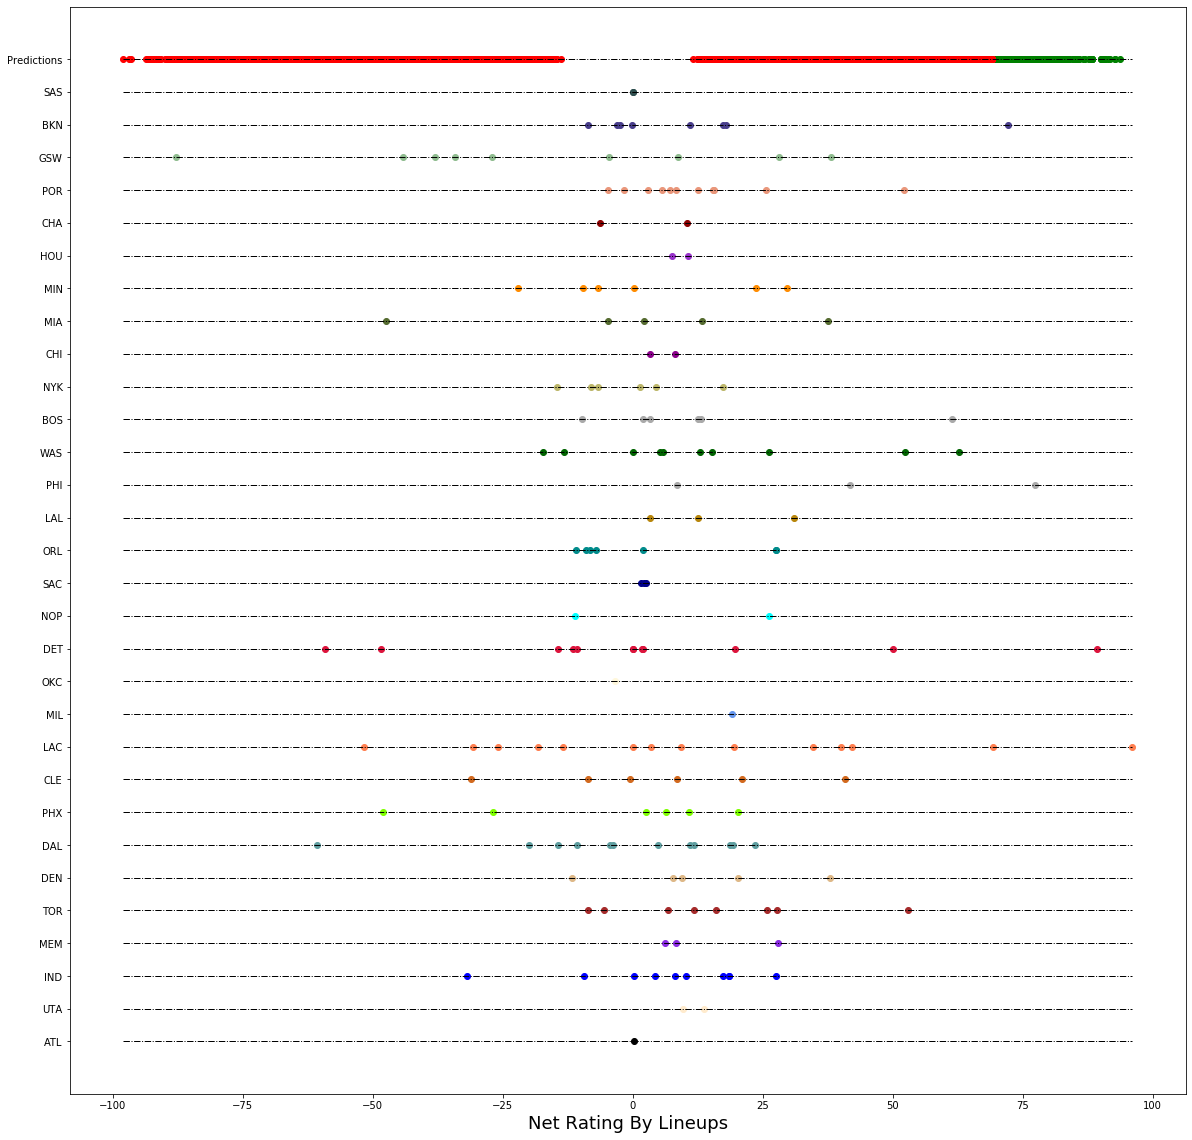

In [15]:
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
colors1 = list(colors.keys())[15:45]
teamcolors = dict(zip(set(new.TEAM),colors1))

fig, ax = plt.subplots(figsize=(20,20))

plotpred = pred_final_restrict.sort_values(by = 'NetRtg', ascending=False)[pred_final_restrict.sort_values(by = 'NetRtg', ascending=False).NetRtg >= max(new[new.TEAM == 'LAC'].NetRtg.drop(129, axis = 0))]
plotrej = pred_final_restrict.sort_values(by = 'NetRtg', ascending=False)[452:]

teamcolorslist = []
for x in set(new.TEAM):
    ax.plot([min(plotrej.NetRtg),max(new.NetRtg)], [x,x], linestyle='-.', color='k', linewidth=1)
    teamcolorslist = []

for idx, x in enumerate(new.TEAM):
    ax.scatter(new.NetRtg.iloc[idx], x, color=teamcolors[x])
    
ax.plot([min(plotrej.NetRtg),max(new.NetRtg)], ['Predictions','Predictions'], linestyle='-.', color='k', linewidth=1)
ax.scatter(plotpred.NetRtg, ['Predictions']*len(plotpred.NetRtg), color='g')
ax.scatter(plotrej.NetRtg, ['Predictions']*len(plotrej.NetRtg), color='r')

ax.set_xlabel('Net Rating By Lineups', fontsize=18)

plt.show()

<a id='fw'></a>

[Back to Top of Notebook](#toc)
## Future Work

- Create model and predict different metrics to evaluate lineup performance, possibly a score that is some sort of comnbination of evaluation metrics
- Find a better method to compute relative per minute statistics for test and train data
- Explore ways to quantify team chemistry, and other non-statistical variables that affect a lineups performance (i.e. playing in more pressured moments)
- Try different regression models such as NN or tree model